<a href="https://colab.research.google.com/github/dev2lot/TicTacToe/blob/main/Colorization_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Dense, Reshape, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as k
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
(xtrain,_),(xtest,_) = cifar10.load_data()

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])   #RGB TO Grayscale conversion
img_rows = xtrain.shape[1]
img_cols = xtrain.shape[2]
img_channels = xtrain.shape[3]

xtrain_gray = rgb2gray(xtrain)
xtest_gray = rgb2gray(xtest)

print(xtrain.shape)
print(xtrain_gray.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
(50000, 32, 32, 3)
(50000, 32, 32)


In [4]:
xtrain  = xtrain.reshape(-1,img_rows, img_cols, img_channels)
xtest  = xtest.reshape(-1,img_rows, img_cols, img_channels)
xtrain_gray = xtrain_gray.reshape(-1,img_rows, img_cols, 1)
xtest_gray  = xtest_gray.reshape(-1,img_rows, img_cols, 1)

xtrain  = xtrain.astype('float32')/255.0
xtest  = xtest.astype('float32')/255.0
xtrain_gray = xtrain_gray.astype('float32')/255.0
xtest_gray  = xtest_gray.astype('float32')/255.0




In [5]:
input_size = (img_rows, img_cols, 1)
kernel_size = 3
batch_size = 32
latent_dim = 256
layer_filters = [64,128,256]

In [6]:
inputs = Input(shape = input_size,name = 'encoder_input')
x = inputs
for filter in layer_filters:
    x = Conv2D(filters = filter,
              kernel_size = kernel_size,
              strides = 2,
              activation = 'relu',
              padding = 'same')(x)

shape = k.int_shape(x)
x = Flatten()(x)

latent = Dense(latent_dim, name = 'latent_vector')(x)
encoder = Model(inputs, latent, name= 'encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_vector (Dense)                │ (None, 256)                 │       1,048,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,418,496 (5.41 MB)

 Trainable params: 1,418,496 (5.41 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
latent_inputs = Input(shape=(latent_dim,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters = filter,
              kernel_size = kernel_size,
              strides = 2,
              activation = 'relu',
              padding = 'same')(x)

outputs = Conv2DTranspose(filters = img_channels,
                         kernel_size = kernel_size,
                          activation = 'sigmoid',
                          padding = 'same')(x)
decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 3)           │           6,915 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,829,827 (10.79 MB)

 Trainable params: 2,829,827 (10.79 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 256)                 │       1,418,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 32, 32, 3)           │       2,829,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,248,323 (16.21 MB)

 Trainable params: 4,248,323 (16.21 MB)

 Non-trainable params: 0 (0.00 B)

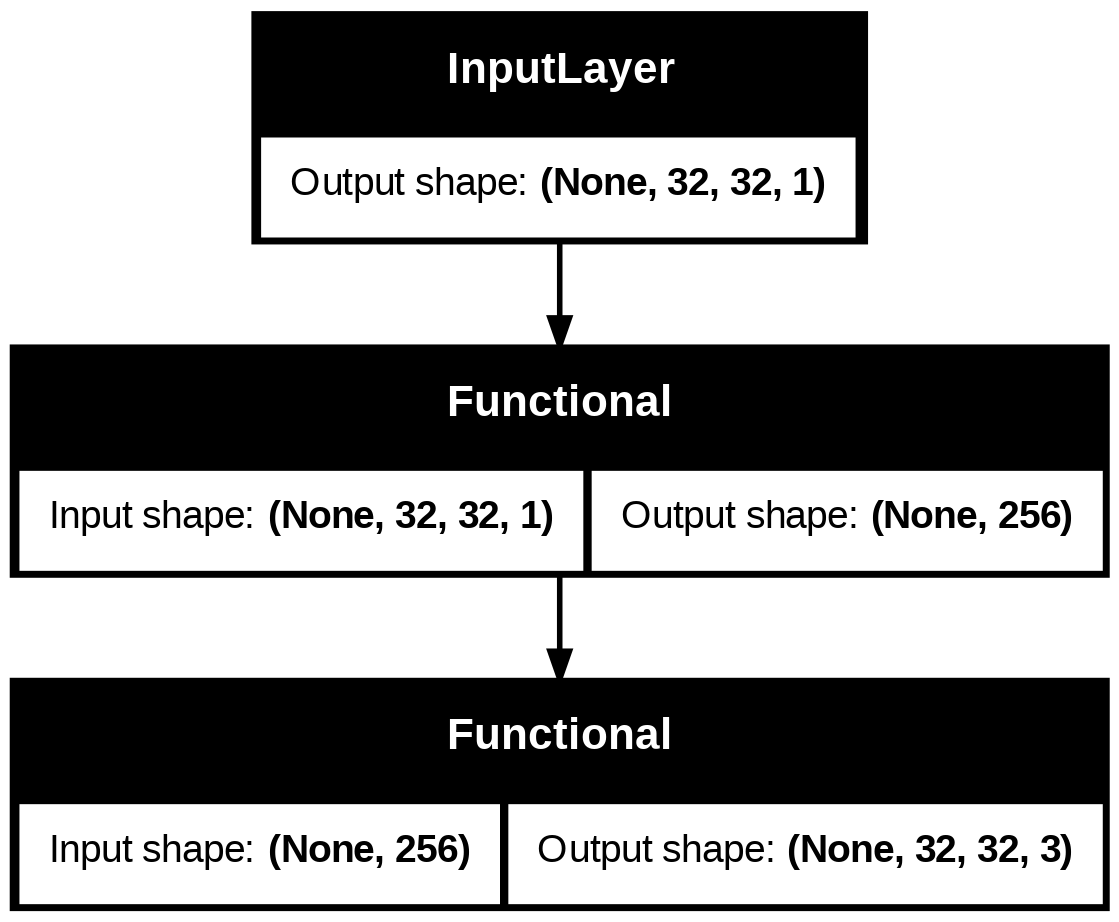

In [8]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name = 'autoencoder')
autoencoder.summary()
plot_model(autoencoder, show_shapes= True)

In [10]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                              cooldown=0,
                              patience=5,
                              min_lr=0.5e-6)
# checkpoint = ModelCheckpoint(filepath= os.path.join(os.getcwd(), 'saved_models'),
                            # monitor='val_loss',
                            # verbose = 1,
                            # save_best_only= True)
autoencoder.compile(loss = 'mse', optimizer = 'adam')
callbacks = [lr_reducer] #, checkpoint]

In [11]:
autoencoder.fit(xtrain_gray,xtrain,
               validation_data=[xtest_gray,xtest],
               epochs = 30,
               batch_size=batch_size,
               callbacks=callbacks)

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - loss: 0.0220 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - loss: 0.0105 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - loss: 0.0093 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0087 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - loss: 0.0083 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 0.0080 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 0.0077 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - loss: 0.0074 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 9/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - loss: 0.0071 - val_loss: 0.007

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


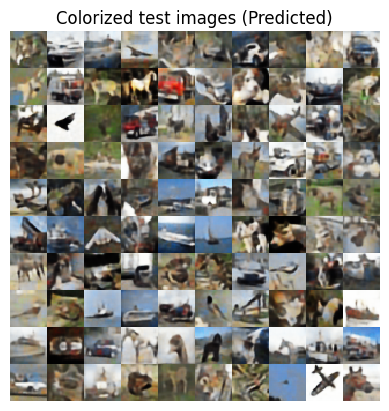

In [12]:
x_decoded = autoencoder.predict(xtest_gray)
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, img_channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
# plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()